Here goes the code to generate the epithelial integrated object and the DR space computation.
It will also contain the plots and code originally planned to go with the clusterDE, DA and entropy notebooks.

In [1]:
library(tidyverse)
library(Seurat)
library(patchwork)
library(ComplexHeatmap)
library(miloR)

── Attaching packages ─────────────────────────────────────── tidyverse 1.3.1 ──

✔ ggplot2 3.3.6      ✔ purrr   0.3.4 
✔ tibble  3.1.8      ✔ dplyr   1.0.10
✔ tidyr   1.2.1      ✔ stringr 1.4.1 
✔ readr   2.1.2      ✔ forcats 0.5.1 

── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()

Warning message in fun(libname, pkgname):
“rgeos: versions of GEOS runtime 3.11.1-CAPI-1.17.1
and GEOS at installation 3.10.3-CAPI-1.16.1differ”
Attaching SeuratObject

Attaching sp

Loading required package: grid

ComplexHeatmap version 2.12.0
Bioconductor page: http://bioconductor.org/packages/ComplexHeatmap/
Github page: https://github.com/jokergoo/ComplexHeatmap
Documentation: http://jokergoo.github.io/ComplexHeatmap-reference

If you use it in published research, please cite:
Gu, Z. Complex heatmaps reveal patterns and correlations in multidimensional 
  genomic data. Bioinformatics 2016.

The 

In [2]:
#Define input directory

    data_dir <- "../ZenodoRepo/"

# Data ingestion and preparation

We will use 21 datasets containing epithelial organoid cells from the experiment.

These individual datasets have been previously loaded into Seurat objects and QC and scaling/normalisation have been applied as shown in the **Exploration** notebook.

To run this section you will need to access the datasets hosted in *DATA REPO* and uncomment the code chunks below.


#Load data

    #Load data from Run 1
    dlist_OrgMonocultures <- readRDS(paste0(data_dir,"jan21_monocultures.rds"))
    dlist_OrgCocultWT <- readRDS(paste0(data_dir,"jan21_crctme_WT.rds"))
    dlist_OrgCocultA <- readRDS(paste0(data_dir,"jan21_crctme_A.rds"))
    dlist_OrgCocultAK <- readRDS(paste0(data_dir,"jan21_crctme_AK.rds"))
    dlist_OrgCocultAKP <- readRDS(paste0(data_dir,"jan21_crctme_AKP.rds"))

    #Load data from the second run
    dlist_Run2 <- readRDS(paste0(data_dir, "aug21_WTorg.rds"))
    
    #Prepare both object lists
    dlist_Run1 <- c(
        dlist_OrgMonocultures, dlist_OrgCocultWT, dlist_OrgCocultA,
        dlist_OrgCocultAK, dlist_OrgCocultAKP)
    rm(dlist_OrgMonocultures, dlist_OrgCocultWT, dlist_OrgCocultA,
        dlist_OrgCocultAK, dlist_OrgCocultAKP)
    for (i in 1:length(dlist_Run1)) {
        print(dlist_Run1[[i]]@project.name)
        names(dlist_Run1)[i] <- dlist_Run1[[i]]@project.name
        dlist_Run1[[i]]@meta.data$clusters <- dlist_Run1[[i]]@active.ident
        dlist_Run1[[i]]@active.assay <- "RNA"
    }
    for (i in 1:length(dlist_Run2)) {
        print(dlist_Run2[[i]]@project.name)
        names(dlist_Run2)[i] <- dlist_Run2[[i]]@project.name
        dlist_Run2[[i]]@meta.data$clusters <- dlist_Run2[[i]]@active.ident
        dlist_Run2[[i]]@active.assay <- "RNA"
    }

#View objects from the 1st run

    for (i in 1:length(dlist_Run1)) {
        p1 <- DimPlot(dlist_Run1[[i]], reduction = "pca", group.by = "clusters") +
            egg::theme_article()
        p2 <- FeaturePlot(dlist_Run1[[i]], reduction = "pca",
            features = c("Epcam", "Pdgfra","Ptprc"), combine = FALSE)
        print(p1+p2+
            plot_layout(ncol=2, nrow = 2)+
            plot_annotation(title=names(dlist_Run1)[i],
                tag_levels = "A")
        )
    }

#View objects from the 2nd run

    for (i in 1:length(dlist_Run2)) {
        p1 <- DimPlot(dlist_Run2[[i]], reduction = "pca", group.by = "clusters") +
            egg::theme_article()
        p2 <- FeaturePlot(dlist_Run2[[i]], reduction = "pca",
            features = c("Epcam", "Pdgfra","Ptprc"), combine = FALSE)
        print(p1+p2+
            plot_layout(ncol=2, nrow = 2)+
            plot_annotation(title=names(dlist_Run2)[i],
                tag_levels = "A")
        )
    }

#Select epithelial clusters and merge both lists

    #1st Run
    for (i in 1:length(dlist_Run1)) {
    dlist_Run1[[i]] <- subset(dlist_Run1[[i]], idents = levels(
        dlist_Run1[[i]]@meta.data$clusters)[startsWith(levels(dlist_Run1[[i]]@meta.data$clusters),
        "e")]
        )
    }
    dlist_INTepi <- dlist_Run1
    #2nd Run
    dlist_INTepi <- append(dlist_INTepi,
        c(
            subset(dlist_Run2[[1]], subset = clusters %in% c(1)),
            subset(dlist_Run2[[2]], subset = clusters %in% c(1)),
            subset(dlist_Run2[[3]], subset = clusters %in% c(2)),
            dlist_Run2[[4]],
            dlist_Run2[[5]]
        ))
    for (i in 1:length(dlist_INTepi)) {
        names(dlist_INTepi)[i] <- dlist_INTepi[[i]]@project.name
    }
    dlist_INTepi

# Integration

The datasets are integrated using Seurat's workflow for RPCA integration of datasets normalised via SCTransform with the following key parameters:

* SelectIntegrationFeatures(
    nfeatures = 4000
    )
* FindIntegrationAnchors(
    normalization.method = "SCT",
    reduction = "rpca", 
    k.anchor = 12
    )

As this computation requires over 50GB of memory, we have hosted the resulting integrated object in *DATA REPO*.
Alternatively, a downsampled version of the integrated object (with just the *RNA* assay) is stored locally in this repository and can be used to explore gene expression and metadata values on the integrated DR space.

Filtering parameters where chosen as shown in the Preprocessing notebook, with a somewhat lenient (for epithelial cells) nFeature_RNA threshold at 1660.

Furthermore, cells with no expression for any of some bona fide highly expressed pan-epithelial markers were also removed from the object as follows:

    subset(SeuratObject,
        subset = Epcam>0 & Krt8>0 & Krt19>0 & Krt18>0 & Cldn7>0)

<!-- Cells with an scaled Dcn expression over 1.4 were labelled with a metadata column. 
These mostly fall within the TA2 cluster and might be doublets, but we were unable to unequivocally identify them.

    fibrolike_cells <- INTepi21_filt@meta.data %>%
                        rownames_to_column() %>%
                        mutate(fibrolike = case_when(
                                    rowname %in%  WhichCells(INTepi21_filt, expression = `Dcn`>=1.4) ~ "1",
                                    TRUE ~ "0",
                                    ),
                            .keep="used"
                            ) %>%
                        column_to_rownames(var="rowname")
    INTepi21_filt <- AddMetaData(INTepi21_filt, fibrolike_cells,
                                col.name = "fibrolike")

    DimPlot(INTepi21_filt,
            reduction = "phate", group.by = "curatedCLUST", split.by = "fibrolike",
            label = TRUE, label.box = FALSE, shuffle = TRUE, repel = TRUE) -->

#Load full object from data repo:

    INTepi <- readRDS(paste0(data_dir,"INTepi.rds"))
    INTepi

#Make subsampled version without outlier cells and balanced cell number per cluster

    INTepi = SetIdent(INTepi, value="curatedCLUST")
    downsampled_INTepi <- subset(INTepi, 
        subset= curatedCLUST !="Outlier 1 (Stressed?)" &
            curatedCLUST !="Outlier 2 (CRC?)")
    downsampled_INTepi <- subset(downsampled_INTepi, downsample = 36)
    downsampled_INTepi@assays$SCT <- NULL
    downsampled_INTepi@assays$UCellRanks <- NULL
    saveRDS(downsampled_INTepi, "data/downsampled_INTepi.rds")

In [3]:
#Load subsampled object

    downsampled_INTepi <- readRDS("data/downsampled_INTepi.rds")

# Dimensionality Reduction and clusters

Replicate the necessary steps to reproduce Figure 2A.
The random seed to generate the PHATE embedding was not saved, so you can either
use the phate_epi DimRed layer already stored in the object or generate a new
similar one with the code below.

#Compute and view DR embeddings

    INTepi <- RunPCA(INTepi,
        assay = "integrated", reduction.name = "pca_ntbk")

    phate_dr <- phateR::phate(
        INTepi@reductions$pca@cell.embeddings,
        knn = 5, decay = 40, t = "auto",
        knn.dist.method = "euclidean",
        mds.solver = "sgd", mds.method = "metric", mds.dist.method = "euclidean",
        n.jobs = 1, seed = 12)
    INTepi[["phate_ntbk"]] <- CreateDimReducObject(embeddings = phate_dr$embedding,
        key = "PHATE_", assay = "integrated")

    p1 <- DimPlot(INTepi, 
        reduction = "pca_epi", group.by = "orig.ident", label = FALSE, shuffle = TRUE)
    p2 <- DimPlot(INTepi,
        reduction = "pca_ntbk", group.by = "orig.ident", label = FALSE, shuffle = TRUE)
    p3 <- DimPlot(INTepi, 
        reduction = "phate_epi", group.by = "orig.ident", label = FALSE, shuffle = TRUE)
    p4 <- DimPlot(INTepi,
        reduction = "phate_ntbk", group.by = "orig.ident", label = FALSE, shuffle = TRUE)
    p1 + p2 + p3 + p4 + plot_layout(
        ncol = 1, nrow=4, guides = "collect") + plot_annotation(
            title = "DR Embeddings", 
            tag_levels = "A")

The clusters shown throughout the paper were based on the unsupervised clusters
found by using the Leiden algorithm with a resolution of 0.6 on a kNN graph built 
from the first 48 PC components and Seurat's integrated assay information.

    INTepi <- FindNeighbors(INTepi,
        reduction = "pca", dims = 1:48, assay = "integrated", 
        k.param = 20, prune.SNN = 1/15, n.trees = 50, annoy.metric = "euclidean", l2.norm = FALSE)

    INTepi <- FindClusters(INTepi,
        resolution = c(0.2,0.4,0.6,0.8),
        algorithm = 4, verbose = TRUE)

We then merged some of the clusters based on gene expression and their relationships across multiple clustering resolution levels as shown in the clustree section of the Exploration notebook.

#Creating the curated annotated cluster layer

    clustree(INTepi, prefix = "integrated_snn_res.",
        layout= c("sugiyama"), node_colour="sc3_stability")

    cluster_metadata <- INTepi@meta.data %>%
        transmute(newclust = case_when(
            integrated_snn_res.0.6 %in% c("13", 
                                "16") ~ "TA 2",
            integrated_snn_res.0.6 %in% c("1") ~ "revCSC",
            integrated_snn_res.0.6 %in% c("4", 
                                "5", 
                                "6") ~ "proCSC",
            integrated_snn_res.0.6 %in% c("2") ~ "CSC",
            integrated_snn_res.0.6 %in% c("9", 
                                "10") ~ "Early Enterocyte",
            integrated_snn_res.0.6 %in% c("3", 
                                "8") ~ "TA 1",
            integrated_snn_res.0.6 %in% c("7", 
                                "15") ~ "Late Enterocyte",
            integrated_snn_res.0.6 %in% c("11") ~ "Goblet / DCS",
            integrated_snn_res.0.6 %in% c("12", 
                                "14") ~ "ER Stress",
            integrated_snn_res.0.6 %in% c("17") ~ "Outlier 1 (Stressed?)",
            integrated_snn_res.0.6 %in% c("18") ~ "Outlier 2 (CRC?)",
            TRUE ~ orig.ident
        ))

    INTepi <- AddMetaData(INTepi, cluster_metadata,col.name = "curatedCLUST")

In [4]:
    curatedCLUST_palette <- c(
        "revCSC" = "#CC0000",
        "proCSC" = "#000099",
        "CSC" = "#6666FF",
        "TA 2" = "#FF6666",
        "TA 1" = "#FF99CC",
        "ER Stress" = "#CC00FF",
        "Early Enterocyte" = "#00FF99",
        "Late Enterocyte" = "#006600",
        "Goblet / DCS" = "#CC9900"
        # "Outlier 1 (Stressed?)" = "#CC99CC",#CC99CC
        # "Outlier 2 (CRC?)" = "#9999CC"#9999CC
    )

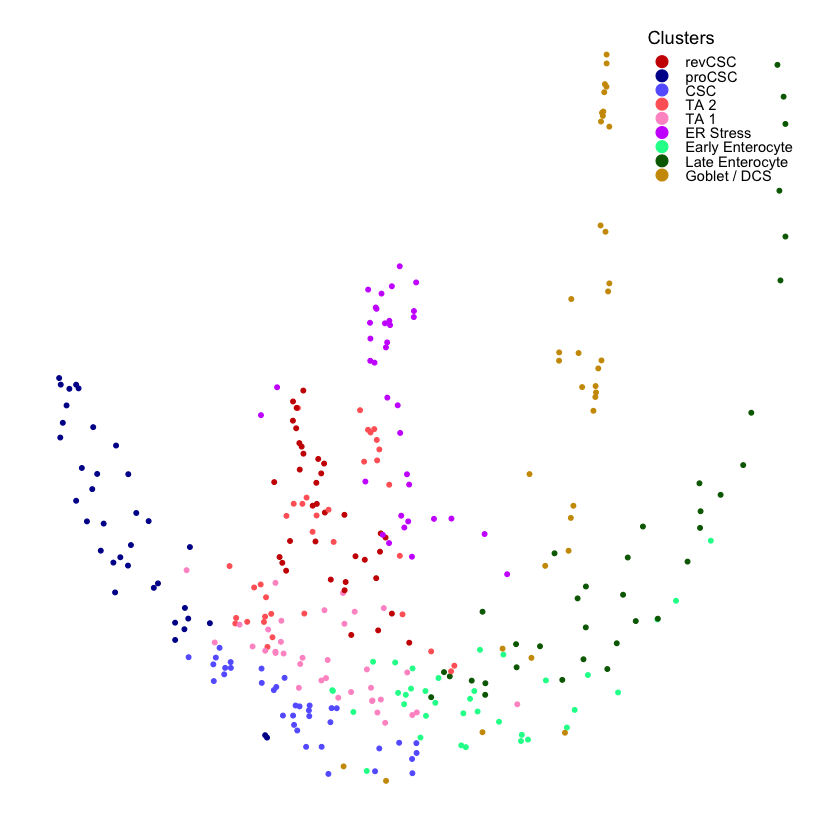

In [5]:
#Recreate Figure 2 A with the subsampled object:

    DimPlot(
        downsampled_INTepi, reduction = "phate_epi",
        group.by = "curatedCLUST", 
        cols = curatedCLUST_palette,
        label = FALSE, label.box = FALSE, 
        shuffle = TRUE, repel = FALSE
        ) +
    egg::theme_article() + #Minimalist theme
    theme(
        legend.position = c(.98, 1),
        legend.justification = c("right", "top"),
        legend.box.just = "right",
        legend.margin = margin(6, 6, 6, 6),
        axis.text = element_blank(),
        axis.ticks=element_blank(),
        panel.border = element_blank() #No boxes
        ) +
    labs(title = NULL, x=NULL, y=NULL, colour="Clusters")

# Curated Heatmap

The Heatmap shown in Figure 2 panel reflects a list of genes found by performing 
DE with Seurat's wilcoxon method across metadata annotations reflecting cluster, 
sample (orig.ident), and DA neighbourhood information.

Within the main Data folder, a .csv file contains this list of genes and their 
annotations as shown in the manuscript.

In [6]:
#Load genelist from csv file
    EPI_geneSet <- read_csv("../Data/CuratedEpithelia_geneSet.csv")
    EPI_geneSet

Rows: 59 Columns: 2
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (2): GENE, ANNOTATION

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


GENE,ANNOTATION
<chr>,<chr>
Lgr5,CSC
Pla2g2a,CSC
Lrig1,CSC
Smoc2,CSC
Aqp5,CSC
Agr2,CSC
Cenpa,proCSC
Hmgb2,proCSC
Birc5,proCSC


In [7]:
#Gene expression matrix from the curated gene list

    mat_geneSet <- downsampled_INTepi[["RNA"]]@scale.data[EPI_geneSet$GENE,] %>%
        as.matrix()

In [8]:
#Colour palettes for the Heatmap

    palette_OrigID <- c()
    for (i in 1:length(levels(downsampled_INTepi@meta.data$orig.ident))) {
        palette_OrigID[
            levels(
            downsampled_INTepi@meta.data$orig.ident
                )[i]
                        ] <- scales::hue_pal()(
                            length(levels(
                                downsampled_INTepi@meta.data$orig.ident))
                                                )[i]
    }

    palette_genotype <- c(
                        "WT"="#079601", 
                        "A"="#BFBFFF",
                        "AK"="#7F7FFF", 
                        "AKP"="#4040FF"
                        )
    palette_macro <- c(
                        "0"="#FFFFFF",
                        "1"="#5E5E5E"
                        )
    palette_fibro <- c(
                        "0"="#FFFFFF",
                        "1"="#FF2600"
                        )
    palette_wenr <- c(
                        "0"="#FFFFFF",
                        "1"="#FF9300"
                        )

    htmp_anno <- HeatmapAnnotation(
        genotype = downsampled_INTepi@meta.data$Genotype,
        fibro = downsampled_INTepi@meta.data$fib,
        macro = downsampled_INTepi@meta.data$mac,
        wenr = downsampled_INTepi@meta.data$WENR,
        OrigID = downsampled_INTepi@meta.data$orig.ident,
        col=list(OrigID = palette_OrigID,
                genotype = palette_genotype,
                fibro = palette_fibro,
                macro = palette_macro,
                wenr = palette_wenr
                )
    )

'magick' package is suggested to install to give better rasterization.

Set `ht_opt$message = FALSE` to turn off this message.



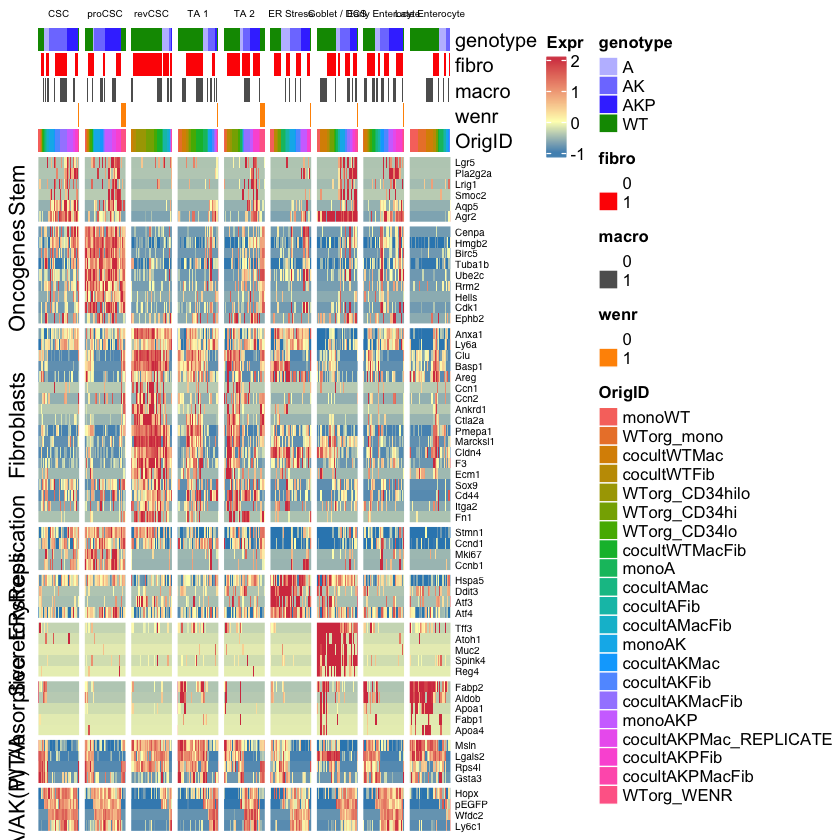

In [9]:
#Plot curated Heatmap: Note that to exactly recreate the one shown in the 
#manuscript one would need to use the full object, and not the subsampled version as shown below.

    Heatmap(
        mat_geneSet, 
        name = "Expr",
        column_order = rownames(
            downsampled_INTepi@meta.data %>% rownames_to_column() %>% 
            group_by(orig.ident) %>% 
            column_to_rownames("rowname") %>% arrange(orig.ident)
                                ),
        column_split = downsampled_INTepi@meta.data$curatedCLUST,
        cluster_columns = FALSE,
        show_column_dend = FALSE, cluster_column_slices = FALSE,
        column_title_rot = 0,
        column_title_gp = gpar(fontsize=6),
        column_gap = unit(1.2, "mm"), show_column_names = FALSE,
        cluster_row_slices = FALSE, cluster_rows = FALSE,
        row_split = factor(
            c(
                rep("Stem", 6),
                rep("Oncogenes", 9),
                rep("Fibroblasts", 18),
                rep("Replication", 4),
                rep("ERstress", 4),
                rep("Secretory", 5),
                rep("Absorptive", 5),
                rep("WT/A", 4),
                rep("A/AK(P)", 4)
            ),
            levels = c(
                "Stem","Oncogenes", "Fibroblasts", 
                "Replication", "ERstress", 
                "Secretory", "Absorptive",
                "WT/A", "A/AK(P)"
                    )
            ),
        row_names_gp = gpar(fontsize=6, fontfamily="Helvetica"),
        top_annotation = htmp_anno,
        use_raster = TRUE,raster_quality = 2,
        col=circlize::colorRamp2(
            c(
                round(quantile(mat_geneSet, 
                    c(0.04,0.96))[1], digits = 1),
                0, 
                round(quantile(mat_geneSet, 
                    c(0.04,0.96))[2], digits = 1)
            ), 
            c("#3288BD", "#FEFEBD", "#D53E4F")
        )
    )

# Differential Abundance

Differential Abundance analysis performed using the miloR package (ADD REF).

Summary of DA changes across all conditions (with no sample grouping)

#Compute neighbourhoods on SCE object constructed from the integrated Seurat object

    #Ensure proper orig.ident levels
    levels(INTepi@meta.data$orig.ident)
    #Create Milo objects
    miloVS_list <- c()
    for (i in 3:length(levels(INTepi@meta.data$orig.ident))) {
    #Use assign to create variables
    assign(paste0("miloVS_", #Name of variable depends on origident
                    levels(INTepi@meta.data$orig.ident)[i]),
            Milo(as.SingleCellExperiment(subset(INTepi, #Origident+controls
                                            subset = orig.ident %in% c(
                                            "monoWT","WTorg_mono",
                                            levels(INTepi@meta.data$orig.ident)[i]
                                                                        )
                                            ),
                                        assay="integrated" #Use integrated assay!
                                        )
                )
            )
    miloVS_list <- list(
                    miloVS_cocultWTMac, miloVS_cocultWTMacFib, miloVS_cocultWTFib,
                    miloVS_WTorg_CD34hilo,miloVS_WTorg_CD34hi,miloVS_WTorg_CD34lo,
                    miloVS_monoA,miloVS_cocultAMac,miloVS_cocultAMacFib, miloVS_cocultAFib,
                    miloVS_monoAK,miloVS_cocultAKMac,miloVS_cocultAKMacFib,miloVS_cocultAKFib,
                    miloVS_monoAKP,miloVS_cocultAKPMac_REPLICATE,miloVS_cocultAKPMacFib,miloVS_cocultAKPFib,
                    miloVS_WTorg_WENR
                    )
    rm(miloVS_cocultWTMac, miloVS_cocultWTMacFib, miloVS_cocultWTFib,
                    miloVS_WTorg_CD34hilo,miloVS_WTorg_CD34hi,miloVS_WTorg_CD34lo,
                    miloVS_monoA,miloVS_cocultAMac,miloVS_cocultAMacFib, miloVS_cocultAFib,
                    miloVS_monoAK,miloVS_cocultAKMac,miloVS_cocultAKMacFib,miloVS_cocultAKFib,
                    miloVS_monoAKP,miloVS_cocultAKPMac_REPLICATE,miloVS_cocultAKPMacFib,miloVS_cocultAKPFib,
                    miloVS_WTorg_WENR)
    ```

    for (i in 1:length(miloVS_list)) {
    #Unfactorize orig.ident -> avoids error with countCells
    miloVS_list[[i]]@colData$orig.ident <- as.character.factor(
                                                miloVS_list[[i]]@colData$orig.ident) 
    #knn  
    miloVS_list[[i]] <- buildGraph(miloVS_list[[i]], k=30, d=48) 
    #Defining neighborhoods
    miloVS_list[[i]] <- makeNhoods(miloVS_list[[i]], prop = 0.24, #higher props more efficient
                            k=30, d=48, refined = TRUE)
    #Count cells in neighbourhoods: -> Choose orig.ident as sample and label as condition!
    miloVS_list[[i]] <- countCells(miloVS_list[[i]], meta.data = miloVS_list[[i]]@colData, samples="orig.ident")
    #Compute neighbourhood connectivity
    miloVS_list[[i]] <- calcNhoodDistance(miloVS_list[[i]], d=48)
    #Nhoodgraph
    miloVS_list[[i]] <- buildNhoodGraph(miloVS_list[[i]], overlap = 6)
    
    }

#Define experimental design for the DA test

    expdesign_pairLIST <- list()
    for (i in 1:length(miloVS_list)) {
        expdesign_pairLIST[[i]] <- distinct(data.frame(
                                    miloVS_list[[i]]@colData[,
                                                            c("orig.ident",
                                                                "CRCTME", "experiment")])
                                    )
        rownames(expdesign_pairLIST[[i]]) <- expdesign_pairLIST[[i]]$orig.ident #Names rows as samples/orig.ident
        expdesign_pairLIST[[i]] <- droplevels(expdesign_pairLIST[[i]]) #Drop unused levels, otherwise error in DA test
    }
    dares_pairLIST <- list()
    for (i in 1:length(miloVS_list)) {
        dares_pairLIST[[i]] <- testNhoods(miloVS_list[[i]], 
                                        design = model.matrix(~ CRCTME,
                                                                data = expdesign_pairLIST[[i]]),
                                        design.df = na.omit(expdesign_pairLIST[[i]])
                                        )
        print(dares_pairLIST[[i]] %>% arrange(SpatialFDR) %>% head())
    }
    for (i in 1:length(miloVS_list)) {
        dares_pairLIST[[i]] <- annotateNhoods(miloVS_list[[i]], dares_pairLIST[[i]], coldata_col = "curatedCLUST")
    }
    for (i in 1:length(miloVS_list)) {
        names(dares_pairLIST)[i] <- paste0(
                                    unique(miloVS_list[[i]]@colData$orig.ident), 
                                    collapse = "_")
    }
    #Construct dataframe with DA results
    dares_pair <- bind_rows(dares_pairLIST, .id = "id") %>% 
                group_by(id, finalCLUST) %>% 
                summarise(md_LFC = median(logFC), 
                            md_sFDR = median(SpatialFDR), 
                            Count=n()) %>%
                mutate(id = case_when(
                                id == "monoWT_cocultAFib_WTorg_mono" ~ "A_Fib",
                                id == "monoWT_cocultAKFib_WTorg_mono" ~ "AK_Fib",
                                id == "monoWT_cocultAKMac_WTorg_mono" ~ "AK_Mac",
                                id == "monoWT_cocultAKMacFib_WTorg_mono" ~ "AK_Mac_Fib",
                                id == "monoWT_cocultAKPFib_WTorg_mono" ~ "AKP_Fib",
                                id == "monoWT_cocultAKPMac_REPLICATE_WTorg_mono" ~ "AKP_Mac",
                                id == "monoWT_cocultAKPMacFib_WTorg_mono" ~ "AKP_Mac_Fib",
                                id == "monoWT_cocultAMac_WTorg_mono" ~ "A_Mac",
                                id == "monoWT_cocultAMacFib_WTorg_mono" ~ "A_Mac_Fib",
                                id == "monoWT_cocultWTFib_WTorg_mono" ~ "WT_Fib",
                                id == "monoWT_cocultWTMac_WTorg_mono" ~ "WT_Mac",
                                id == "monoWT_cocultWTMacFib_WTorg_mono" ~ "WT_Mac_Fib",
                                id == "monoWT_monoA_WTorg_mono" ~ "A",
                                id == "monoWT_monoAK_WTorg_mono" ~ "AK",
                                id == "monoWT_monoAKP_WTorg_mono" ~ "AKP",
                                id == "monoWT_WTorg_CD34hi_WTorg_mono" ~ "WT_Fib_CD34h",
                                id == "monoWT_WTorg_CD34hilo_WTorg_mono" ~ "WT_Fib_CD34hl",
                                id == "monoWT_WTorg_CD34lo_WTorg_mono" ~ "WT_Fib_CD34l",
                                id == "monoWT_WTorg_mono_WTorg_WENR" ~ "WT_WENR",
                                TRUE ~ id)
                        ) 
    dares_pair$id <- factor(dares_pair$id, 
                            levels= c(
                            "WT_Mac", "WT_Mac_Fib", "WT_Fib",
                            "WT_Fib_CD34h", "WT_Fib_CD34hl", "WT_Fib_CD34l",
                            "A", "A_Mac", "A_Mac_Fib", "A_Fib",
                            "AK", "AK_Mac", "AK_Mac_Fib", "AK_Fib",
                            "AKP", "AKP_Mac", "AKP_Mac_Fib", "AKP_Fib",
                            "WT_WENR"
                                    )
                            )
    dares_pair$curatedCLUST <- factor(dares_pair$curatedCLUST, 
                            levels= c(
                            "CSC","proCSC","revCSC", 
                            "TA 1","TA 2",
                            "ER Stress",
                            "Goblet / DCS",
                            "Early Enterocyte","Late Enterocyte",
                            "Outlier 1 (Stressed?)","Outlier 2 (CRC?)"
                                    )
                            )

#Add dummy row for the control sample (WT organoid monocultures)

    dares_mockWT <- tribble(
                    ~id, ~curatedCLUST, ~md_LFC, ~md_sFDR, ~Count,
                    "WT", "Early Enterocyte", 0, 0.999, 0, #median(dares_pair$Count),
                    "WT", "ER Stress", 0, 0.999, 0, #median(dares_pair$Count),
                    "WT", "Late Enterocyte", 0, 0.999, 0, #median(dares_pair$Count),
                    "WT", "Goblet / DCS", 0, 0.999, 0, #median(dares_pair$Count),
                    "WT", "CSC", 0, 0.999, 0, #median(dares_pair$Count),
                    "WT", "proCSC", 0, 0.999, 0, #median(dares_pair$Count),
                    "WT", "revCSC", 0, 0.999, 0, #median(dares_pair$Count),
                    "WT", "TA 1", 0, 0.999, 0, #median(dares_pair$Count),
                    "WT", "TA 2", 0, 0.999, 0 #median(dares_pair$Count),
                            )
    DA_resultsOverview <- ungroup(dares_pair) %>% add_row(dares_mockWT) %>% 
                        filter(!(id %in% c(
                                        "WT_Fib_CD34h", "WT_Fib_CD34hl", 
                                        "WT_Fib_CD34l")
                                )
                            ) %>%
                        filter(!(curatedCLUST %in% c(
                                                    "Outlier 1 (Stressed?)",
                                                    "Outlier 2 (CRC?)")
                                )
                            )
```

In [10]:
#Read the DA results and reorder factors as shown in Figure 2
    
    DA_resultsOverview <- read_csv("data/DA_resultsOverview.csv")

    DA_resultsOverview$id <- factor(DA_resultsOverview$id, 
                            levels= c(
                            "WT",
                            "WT_Mac", "WT_Fib", "WT_Mac_Fib", 
                            "A", "A_Mac", "A_Fib", "A_Mac_Fib",
                            "AK", "AK_Mac", "AK_Fib", "AK_Mac_Fib", 
                            "AKP", "AKP_Mac", "AKP_Fib", "AKP_Mac_Fib",
                            "WT_WENR"
                                    )
                            )

    DA_resultsOverview$curatedCLUST <- factor(DA_resultsOverview$curatedCLUST, 
                            levels= c(
                                "CSC","proCSC","revCSC", 
                                "TA 1","TA 2",
                                "ER Stress",
                                "Goblet / DCS",
                                "Early Enterocyte","Late Enterocyte"
                                        )
                            )

Rows: 153 Columns: 5
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (2): id, curatedCLUST
dbl (3): md_LFC, md_sFDR, Count

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


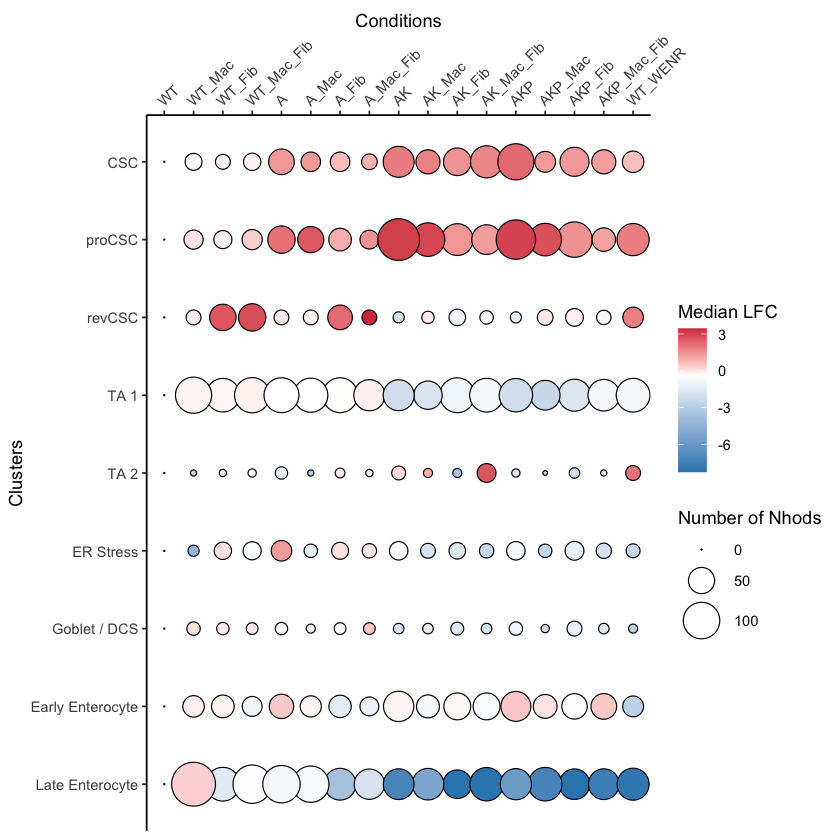

In [11]:
#Make dotplot

    pDApair_DotPlot <- ggplot(
                            DA_resultsOverview, 
                            aes(id, curatedCLUST)) +
                        geom_point(shape=21, aes(x=id, fill=md_LFC, size=Count)) +
                        #geom_label(nudge_x = 0.48, aes(label=Count, alpha=0.6, fontface="bold")) +
                        scale_fill_gradientn(
                        #colors=c("blue","white","red"),
                        colors=c("#3288BD","white","#D53E4F"),
                        values=scales::rescale(c(-8, 0, 4)),
                        guide = "colourbar",
                        aesthetics = "fill"
                                            ) +
                        scale_size_area(max_size = 12) +
                        scale_x_discrete(position = "top") +
                        scale_y_discrete(limits=rev) +
                        theme_classic() +
                        theme(axis.text.x = element_text(angle = 45, hjust = -0)) +
                        labs(x="Conditions", y ="Clusters", 
                            fill="Median LFC", size="Number of Nhods")
    pDApair_DotPlot

Grouping equivalent samples across the 2 runs to increase statistical power

#WT vs WT+Fibroblast coculture

    DA_INTepi_fib <- Milo(as.SingleCellExperiment(
                            subset(INTepi, 
                                subset = orig.ident %in% c(
                                    "monoWT","WTorg_mono",
                                    "cocultWTFib",
                                    "WTorg_CD34hilo","WTorg_CD34hi","WTorg_CD34lo"
                                                            )
                                ), 
                            assay = "integrated"))
    DA_INTepi_fib@colData$orig.ident <- droplevels(DA_INTepi_fib@colData$orig.ident)

    DA_INTepi_fib <- buildGraph(DA_INTepi_fib, k=30, d=48) 
    #Defining neighborhoods
    DA_INTepi_fib <- makeNhoods(DA_INTepi_fib, prop = 0.24, #higher props more efficient
                            k=30, d=48, refined = TRUE)
    DA_INTepi_fib
    #Count cells in neighbourhoods: -> Choose orig.ident as sample and label as condition!
    DA_INTepi_fib <- countCells(DA_INTepi_fib, meta.data = DA_INTepi_fib@colData, samples="orig.ident")
    head(nhoodCounts(DA_INTepi_fib)) #View count results
    #Compute neighbourhood connectivity
    DA_INTepi_fib <- calcNhoodDistance(DA_INTepi_fib, d=48)
    DA_INTepi_fib <- buildNhoodGraph(DA_INTepi_fib, overlap = 6)

    #Test experimental design
    expdesign_stroma <- distinct(
                        data.frame(DA_INTepi_fib@colData[,
                                    c("orig.ident",
                                        "CRCTME", 
                                        "experiment")]
                                    )
                                ) %>%
                        remove_rownames() %>%
                        column_to_rownames(var = "orig.ident") %>%
                        droplevels()
    DA_resultsStroma <- testNhoods(DA_INTepi_fib,
                            design = model.matrix(~ experiment + CRCTME,
                                                    data = expdesign_stroma),
                            design.df = na.omit(expdesign_stroma))
    DA_resultsStroma <- annotateNhoods(DA_INTepi_fib, DA_resultsStroma, coldata_col = "curatedCLUST")

In [12]:
#Read the DA results (local directory) and relevant SCE object (Zenodo repository)

    DA_resultsStroma <- read_csv("data/DA_resultsStroma.csv")
    DA_INTepi_fib <- readRDS(paste0(data_dir,"DA_INTepi_fib.rds"))

Rows: 815 Columns: 9
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (1): curatedCLUST
dbl (8): logFC, logCPM, F, PValue, FDR, Nhood, SpatialFDR, curatedCLUST_frac...

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


Registered S3 method overwritten by 'ggedit':
  method from   
  +.gg   ggplot2

Scale for 'fill' is already present. Adding another scale for 'fill', which
will replace the existing scale.



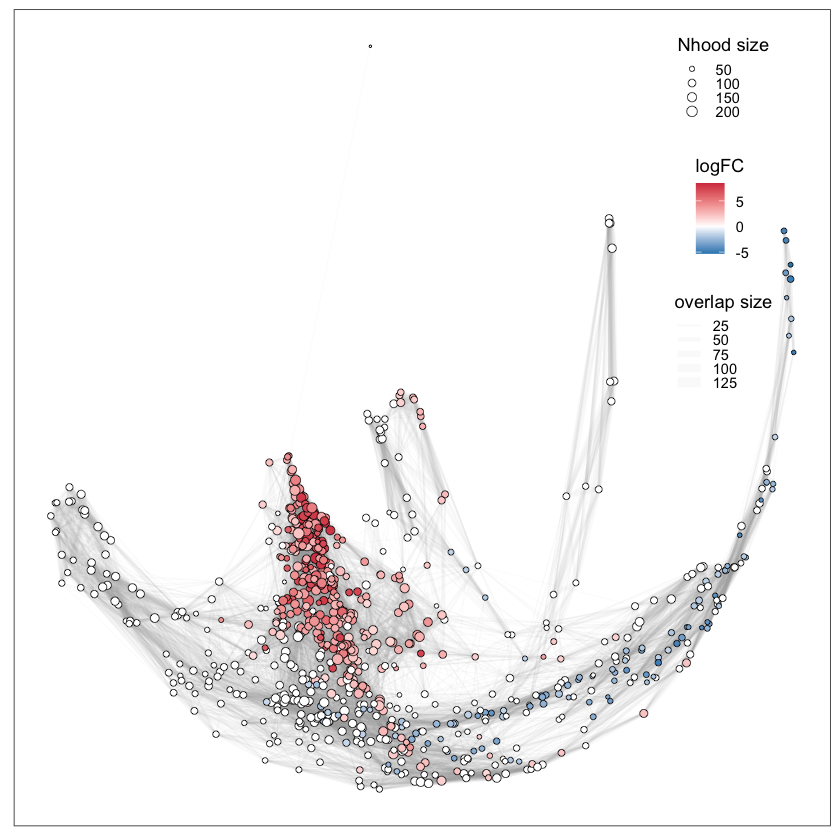

In [13]:
#Generate plot

    pNhDAg_stroma <- plotNhoodGraphDA(
                    DA_INTepi_fib, 
                    DA_resultsStroma, 
                    layout = "PHATE_EPI", 
                    alpha=0.05) %>% ggedit::remove_geom("edge") +
    ggraph::geom_edge_link0(aes(width=weight), 
                            edge_colour="grey66",edge_alpha=0.06, 
                            position = position_identity()
                            ) +
    scale_fill_gradientn(
                        #colors=c("blue","white","red"),
                        colors=c("#3288BD","white","#D53E4F"),
                        values=scales::rescale(c(
                            min(DA_resultsStroma$logFC),
                            0,
                            max(DA_resultsStroma$logFC))),
                        guide = "colourbar",
                        aesthetics = "fill"
                                            ) +
    # scale_fill_gradient2("logFC",
    #                      high = scales::muted("red"), low = scales::muted("blue")
    #                      ) +
    # scale_x_continuous(limits = c(-0.04,0.06), expand = c(0, 0)) +
    # scale_y_continuous(limits = c(-0.06,0.06), expand = c(0, 0)) +
    labs(title = NULL, x=NULL, y=NULL, fill="logFC") +
    egg::theme_article() +
    theme(legend.position = c(.94, .98),
            legend.justification = c("right", "top"),
            legend.box.just = "center",
            legend.margin = margin(6, 6, 6, 6),
            axis.text = element_blank(),
            axis.ticks=element_blank(),
            panel.background = element_blank()
            )
    int_plot <- pNhDAg_stroma
    pNhDAg_stroma$layers[1] <- int_plot$layers[2]
    pNhDAg_stroma$layers[2] <- int_plot$layers[1]
    rm(int_plot)

    pNhDAg_stroma

The WT vs AK/AKP monoculture was generated as above but this time testing the AK and AKP vs the control samples

In [14]:
#Read the DA results (local directory) and relevant SCE object (Zenodo repository)

    DA_resultsGeno <- read_csv("data/DA_resultsGeno.csv")
    DA_INTepi_geno <- readRDS(paste0(data_dir,"DA_INTepi_geno.rds"))

Rows: 881 Columns: 9
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (1): curatedCLUST
dbl (8): logFC, logCPM, F, PValue, FDR, Nhood, SpatialFDR, curatedCLUST_frac...

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


Scale for 'fill' is already present. Adding another scale for 'fill', which
will replace the existing scale.



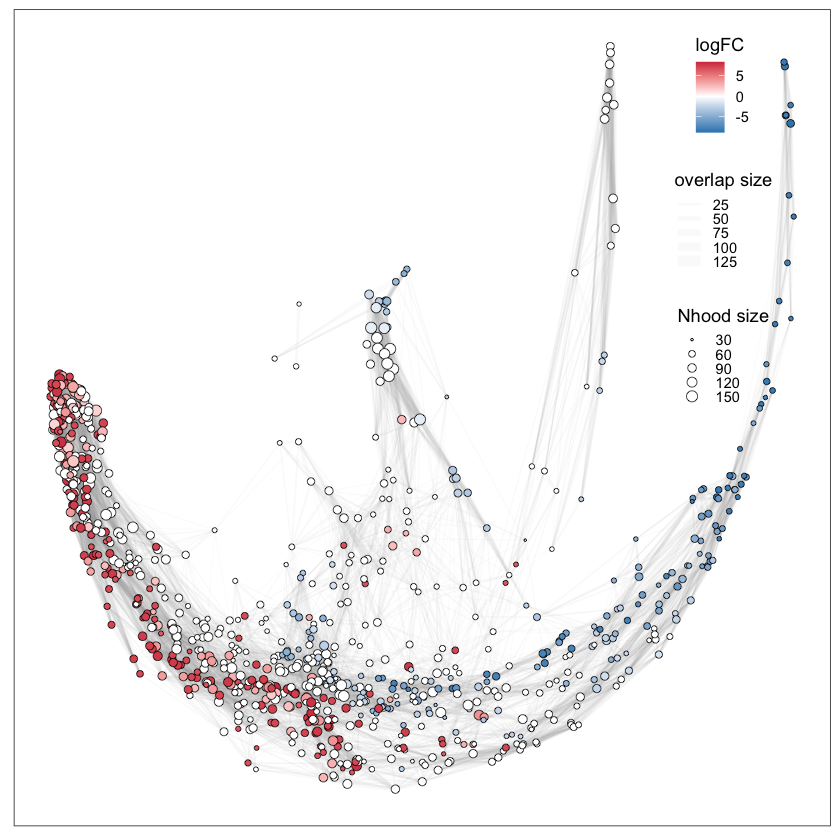

In [15]:
##Generate plot

    pNhDAg_geno <- plotNhoodGraphDA(
                    DA_INTepi_geno, 
                    DA_resultsGeno, 
                    layout = "PHATE_EPI", 
                    alpha=0.05) %>% ggedit::remove_geom("edge") +
    ggraph::geom_edge_link0(aes(width=weight), 
                            edge_colour="grey66",edge_alpha=0.06, 
                            position = position_identity()
                            ) +
    scale_fill_gradientn(
                        #colors=c("blue","white","red"),
                        colors=c("#3288BD","white","#D53E4F"),
                        values=scales::rescale(c(
                            min(DA_resultsGeno$logFC),
                            0,
                            max(DA_resultsGeno$logFC))),
                        guide = "colourbar",
                        aesthetics = "fill"
                                            ) +
    # scale_fill_gradient2("logFC",
    #                      high = scales::muted("red"), low = scales::muted("blue")
    #                      ) +
    # scale_x_continuous(limits = c(-0.04,0.06), expand = c(0, 0)) +
    # scale_y_continuous(limits = c(-0.06,0.06), expand = c(0, 0)) +
    labs(title = NULL, x=NULL, y=NULL, fill="logFC") +
    egg::theme_article() +
    theme(legend.position = c(.94, .98),
            legend.justification = c("right", "top"),
            legend.box.just = "center",
            legend.margin = margin(6, 6, 6, 6),
            axis.text = element_blank(),
            axis.ticks=element_blank(),
            panel.background = element_blank()
            )
    int_plot <- pNhDAg_geno
    pNhDAg_geno$layers[1] <- int_plot$layers[2]
    pNhDAg_geno$layers[2] <- int_plot$layers[1]
    rm(int_plot)

    pNhDAg_geno

# Signalling Entropy

Use the SCENT package to compute the CCAT scores for the cells in the integrated Seurat object.
These scores are based on the concept of Signalling Entropy, which has been proposed as a proxy for stemness and pluripotency.

#Convert SCENT's built-in PPI network dataset into mouse

    biomaRt::listMarts()
    Hmart <- biomaRt::useMart("ENSEMBL_MART_ENSEMBL", dataset = "hsapiens_gene_ensembl")
    Mmart <- biomaRt::useMart("ENSEMBL_MART_ENSEMBL", dataset = "mmusculus_gene_ensembl")
    mart <- biomaRt::getLDS(attributes = c("entrezgene_id","hgnc_symbol"), mart = Hmart, attributesL = c("entrezgene_id","mgi_symbol"), martL = Mmart)

    d_hEntrez2mMGI <- mart %>% select(NCBI.gene..formerly.Entrezgene..ID, MGI.symbol) %>% filter(!is.na(NCBI.gene..formerly.Entrezgene..ID)) %>%
    filter(MGI.symbol!="") %>% distinct()

    test_df <- net17Jan16.m %>% as.data.frame()

    d_hEntrez2mMGI <- d_hEntrez2mMGI %>% filter(as.numeric(NCBI.gene..formerly.Entrezgene..ID) %in% as.numeric(rownames(test_df))) %>% distinct(NCBI.gene..formerly.Entrezgene..ID, .keep_all = TRUE) %>% distinct(MGI.symbol, .keep_all = T)
    d_hEntrez2mMGI

    matched_genes <- match(d_hEntrez2mMGI$NCBI.gene..formerly.Entrezgene..ID,as.numeric(rownames(test_df)))
    summary(matched_genes)

    rownames(test_df)[na.omit(matched_genes)] <- d_hEntrez2mMGI$MGI.symbol[!is.na(matched_genes)]
    colnames(test_df)[na.omit(matched_genes)] <- d_hEntrez2mMGI$MGI.symbol[!is.na(matched_genes)]

    test_df

#Compute CCAT score and add as Metadata layer to the Seurat object

    ccat_RNA <- CompCCAT(exp.m = INTepi@assays$RNA@data, ppiA.m = test_df)
    dccat_RNA  <- ccat_RNA %>% as.data.frame()
    dccat_RNA$Cluster <- INTepi@meta.data$curatedCLUST

    dSCENT_results <- dccat_RNA %>% filter(. > median(.)) %>% group_by(Cluster) %>% summarise(Count = n()) %>% mutate(relAmed = Count/nrow(dccat_RNA %>% filter(. > median(.))))

    dSCENT_results <- left_join(
                                dSCENT_results,
                                dccat_RNA %>% group_by(Cluster) %>% 
                                summarise(CountTOT=n(), relAtot = n()/nrow(dccat_RNA))
                            ) %>% mutate(DAfc = relAmed/relAtot,
                                        DiffCount = Count/CountTOT)

    INTepi <- AddMetaData(INTepi, ccat_RNA ,col.name = "SCENT_ccat")

Scale for 'x' is already present. Adding another scale for 'x', which will
replace the existing scale.

Scale for 'y' is already present. Adding another scale for 'y', which will
replace the existing scale.



<ScaleContinuous>
 Range:  
 Limits:    0 --    1

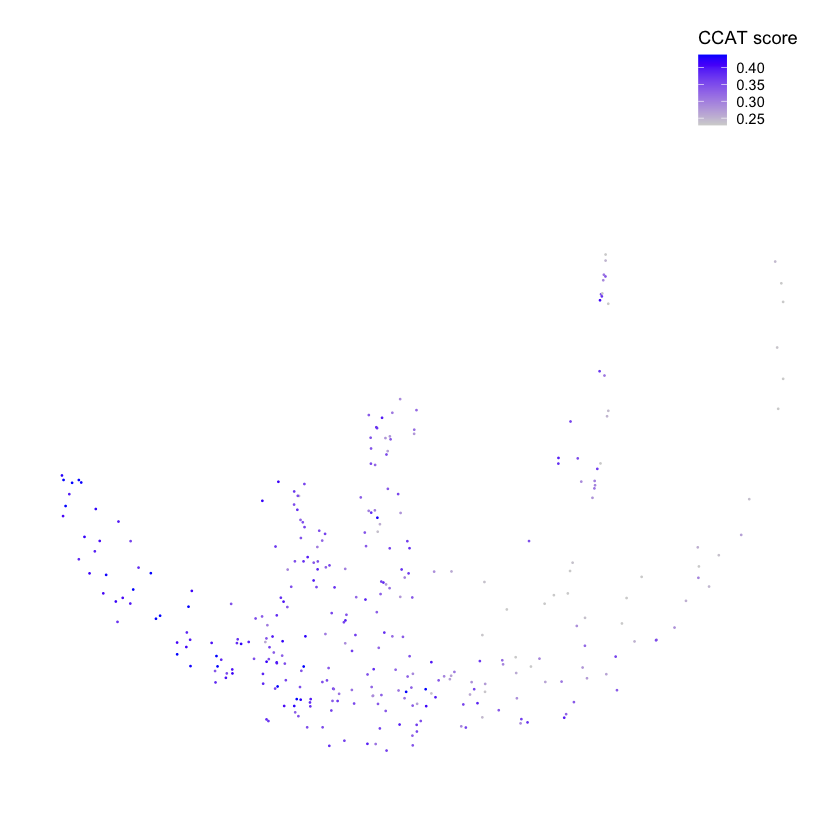

In [16]:
#Reproduce plot from Figure 2 using the downsampled object

    FeaturePlot(
            downsampled_INTepi, 
            features = c("SCENT_ccat"),
            reduction = "phate_epi", blend = FALSE, pt.size = 0.1,
            min.cutoff = "q5", max.cutoff = "q95") +
    scale_x_continuous(limits = c(-0.03327359,0.04614135), expand = c(0, 0)) +
    scale_y_continuous(limits = c(-0.02330382,0.06472699), expand = c(0, 0)) +
    egg::theme_article() + #Minimalist theme
    theme(
        legend.position = c(.98, 1),
        legend.justification = c("right", "top"),
        legend.box.just = "right",
        legend.margin = margin(6, 6, 6, 6),
        axis.text = element_blank(),
        axis.ticks=element_blank(),
        panel.border = element_blank() #No boxes
    ) +
    labs(title = NULL, x=NULL, y=NULL, colour="CCAT score") #+
    scale_color_distiller(palette = "Spectral")

Warning message:
“Number of labels is greater than default palette color count.Select another color `palette` (and/or `package`).”
Scale for 'colour' is already present. Adding another scale for 'colour',
which will replace the existing scale.



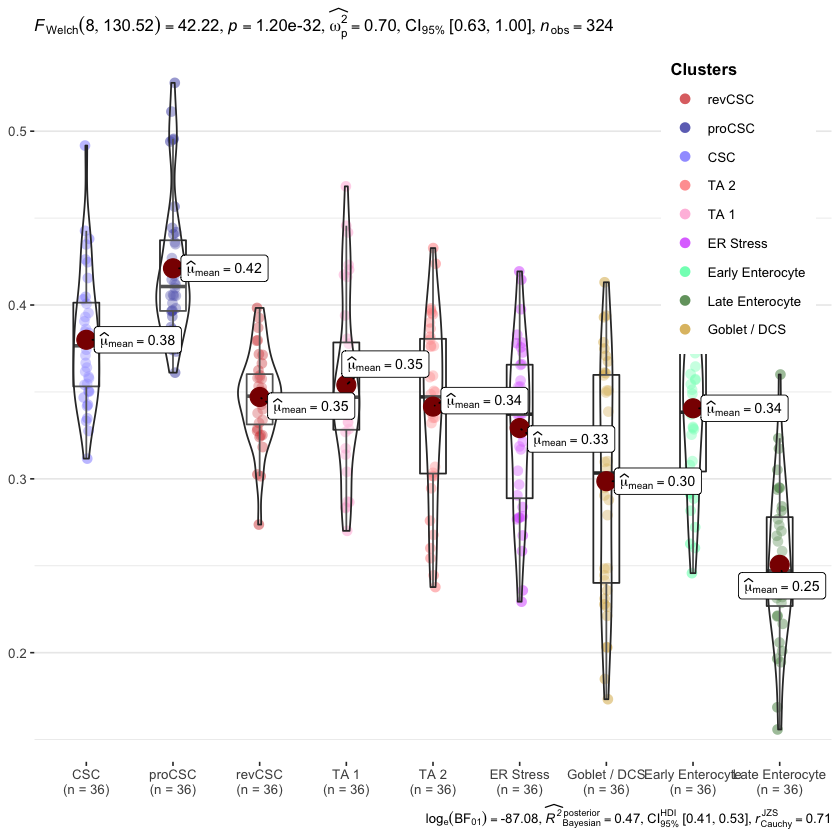

In [17]:
#Reproduce the plot from Fig S2E using the downsampled object

ggstatsplot::ggbetweenstats(
    downsampled_INTepi@meta.data,
    x = curatedCLUST,
    y = SCENT_ccat,
    type="p",
    plot.type = "boxviolin",
    pairwise.comparisons = FALSE,
    pairwise.display = "non-significant"
) +
scale_color_manual(values = curatedCLUST_palette) +
theme(
    legend.position = c(.98, 1),
    legend.justification = c("right", "top"),
    legend.box.just = "right",
    legend.margin = margin(6, 6, 6, 6),
    panel.grid.major.x = element_blank()
) +
labs(title = NULL, x=NULL, y=NULL, colour="Clusters")